# Спортивный анализ данных. Платформа Kaggle. Домашнее задание №3

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. Внимание! выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод
fit
/
train
;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (
train
,
valid
);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (
train
,
valid
,
test
);
* ЛБ - лидерборд, выборка
assignment_2_test.csv

## Загрузим датасет

In [1]:
from typing import List, Optional
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
!pip install catboost
import catboost as cb

     |████████████████████████████████| 65.7MB 44kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка датасета и вывод размерностей

In [3]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

print("data.shape = {} rows, {} cols".format(*data.shape))
print("lb.shape = {} rows, {} cols".format(*lb.shape))

data.shape = 180000 rows, 394 cols
lb.shape = 100001 rows, 394 cols


## Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адекватаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [4]:
data.sort_values(by='TransactionID', inplace=True, ascending=True)

In [5]:
categorical = data.select_dtypes(include='object')
categorical_feature_names = categorical.columns.to_list()

In [6]:
for feature in categorical_feature_names:
    data[feature] = data[feature].astype(str)
    lb[feature] = lb[feature].astype(str)

In [7]:
y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=False, random_state=1,
)

In [9]:
cb_params = {
    "n_estimators": 5000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [10]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6569442	test: 0.6862510	best: 0.6862510 (0)	total: 15.4ms	remaining: 1m 17s
50:	learn: 0.8699310	test: 0.8496917	best: 0.8501460 (49)	total: 633ms	remaining: 1m 1s
100:	learn: 0.8804725	test: 0.8568657	best: 0.8568658 (98)	total: 1.09s	remaining: 53.1s
150:	learn: 0.8852229	test: 0.8594905	best: 0.8600274 (146)	total: 1.58s	remaining: 50.8s
200:	learn: 0.8883339	test: 0.8621852	best: 0.8625875 (199)	total: 2.05s	remaining: 48.9s
250:	learn: 0.8915187	test: 0.8648941	best: 0.8649721 (241)	total: 2.51s	remaining: 47.6s
300:	learn: 0.8947853	test: 0.8668418	best: 0.8670131 (287)	total: 2.98s	remaining: 46.6s
350:	learn: 0.8977611	test: 0.8682740	best: 0.8682740 (350)	total: 3.44s	remaining: 45.6s
400:	learn: 0.8994993	test: 0.8693831	best: 0.8693831 (400)	total: 3.92s	remaining: 45s
450:	learn: 0.9018482	test: 0.8705381	best: 0.8706097 (447)	total: 4.38s	remaining: 44.2s
500:	learn: 0.9038059	test: 0.8713748	best: 0.8713748 (500)	total: 4.85s	remaining: 43.6s
550:	learn: 0.905

In [11]:
train_pred = model_catb.predict_proba(x_train)
valid_pred = model_catb.predict_proba(x_valid)
lb_pred = model_catb.predict_proba(x_lb)

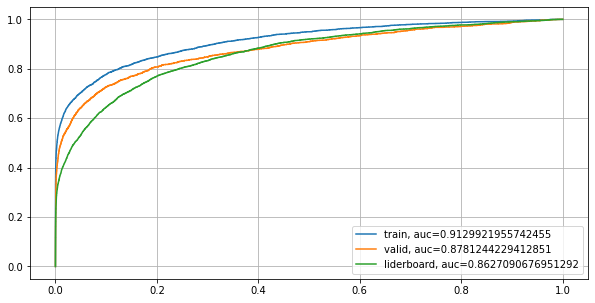

In [12]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_fpr_catb, lb_tpr_catb, _ = metrics.roc_curve(y_lb,  lb_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.plot(lb_fpr_catb, lb_tpr_catb, label="liderboard, auc="+str(lb_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

Вывод: по точечной оценке метрики сложно что-то сказать про переобучение (недообучение). Графики могут говорить как о переобучении, так и о различии в распределениях в разных выборках.

## Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.6, shuffle=False, random_state=1,
)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, y_valid, train_size=0.5, shuffle=False, random_state=1,
)

In [14]:
cb_params = {
    "n_estimators": 5000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [15]:
model_catb_2 = cb.CatBoostClassifier(**cb_params)
model_catb_2.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734405	test: 0.6516944	best: 0.6516944 (0)	total: 14.7ms	remaining: 1m 13s
50:	learn: 0.8667440	test: 0.8543455	best: 0.8544124 (49)	total: 607ms	remaining: 58.9s
100:	learn: 0.8786974	test: 0.8631964	best: 0.8631964 (100)	total: 1.1s	remaining: 53.2s
150:	learn: 0.8830155	test: 0.8656262	best: 0.8656271 (149)	total: 1.54s	remaining: 49.4s
200:	learn: 0.8872234	test: 0.8681548	best: 0.8684465 (193)	total: 2s	remaining: 47.7s
250:	learn: 0.8911725	test: 0.8707543	best: 0.8707982 (245)	total: 2.44s	remaining: 46.2s
300:	learn: 0.8940420	test: 0.8724230	best: 0.8724641 (293)	total: 2.89s	remaining: 45.1s
350:	learn: 0.8975011	test: 0.8746814	best: 0.8746814 (350)	total: 3.35s	remaining: 44.4s
400:	learn: 0.9003988	test: 0.8750458	best: 0.8752197 (359)	total: 3.8s	remaining: 43.6s
bestTest = 0.8752196729
bestIteration = 359
Shrink model to first 360 iterations.


In [16]:
train_pred = model_catb_2.predict_proba(x_train)
valid_pred = model_catb_2.predict_proba(x_valid)
test_pred = model_catb_2.predict_proba(x_test)
lb_pred = model_catb_2.predict_proba(x_lb)

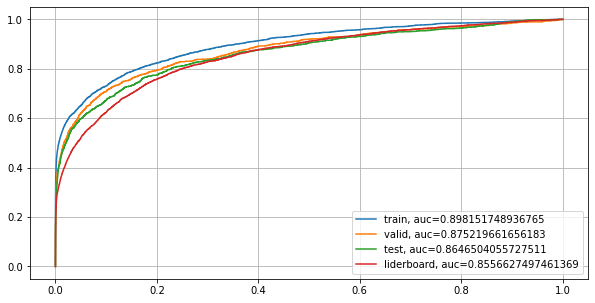

In [17]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
test_fpr_catb, test_tpr_catb, _ = metrics.roc_curve(y_test,  test_pred[:, 1])
test_auc_catb = metrics.roc_auc_score(y_test, test_pred[:, 1])
lb_fpr_catb, lb_tpr_catb, _ = metrics.roc_curve(y_lb,  lb_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.plot(test_fpr_catb, test_tpr_catb, label="test, auc="+str(test_auc_catb))
plt.plot(lb_fpr_catb, lb_tpr_catb, label="liderboard, auc="+str(lb_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

Вывод: картина как и в предыдущем пункте - точечная оценка AUC: train AUC > valid AUC > test AUC > lb AUC. Нужно оценивать AUC интервально. 

## Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [19]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [20]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb_2.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb_2.predict_proba(x_valid)[:, 1], roc_auc_score)
test_scores = create_bootstrap_metrics(y_test, model_catb_2.predict_proba(x_test)[:, 1], roc_auc_score)
lb_scores = create_bootstrap_metrics(y_lb, model_catb_2.predict_proba(x_lb)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Test confidence interval = {calculate_confidence_interval(test_scores)}')
print(f'Lb confidence interval = {calculate_confidence_interval(lb_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.8908878910975863, 0.904834133735017)
Valid confidence interval = (0.8610552458226425, 0.8875907003412824)
Test confidence interval = (0.8531889598983333, 0.8763783919462657)
Lb confidence interval = (0.848809733256666, 0.8626295425337368)
Liderboard score = 0.8556627497461369


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

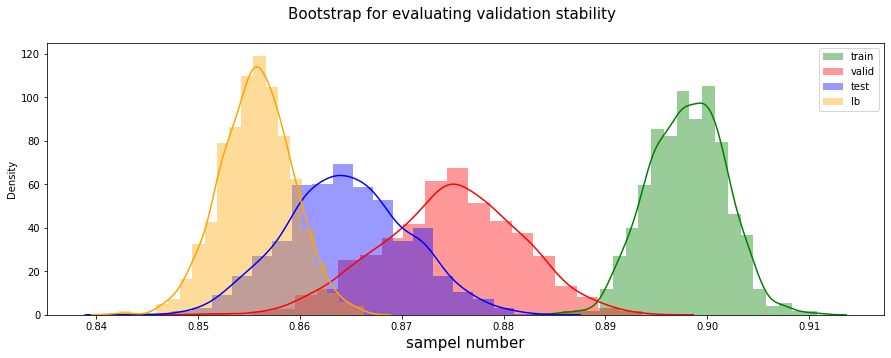

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.distplot(train_scores,  color="green", bins=20, label='train')
sns.distplot(valid_scores,  color="red", bins=20, label='valid')
sns.distplot(test_scores,  color="blue", bins=20, label='test')
sns.distplot(lb_scores,  color="orange", bins=20, label='lb')
plt.xlabel("sampel number", size=15)
plt.legend()

Вывод: результат на liderboard попал в доверительный интервал на тестовой выборке, но оказался близок к границе. Схема валидации по TransactionID скорее всего неправильная, так как доверительные интервалы смещены относительно друг друга на большую величину.

## Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [22]:
x_adv = pd.concat([
    data, lb], axis=0
)
y_adv = np.hstack((np.zeros(data.shape[0]), np.ones(lb.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [23]:
cb_params = {
    "n_estimators": 50,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [24]:
model_catb_3 = cb.CatBoostClassifier(**cb_params)
model_catb_3.fit(x_adv, y_adv, cat_features=categorical_feature_names)

0:	learn: 0.9984656	total: 16.7ms	remaining: 818ms
49:	learn: 0.9990675	total: 599ms	remaining: 0us


In [25]:
y_pred_adv = model_catb_3.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.9991


Алгоритм с легкостью отличил две выборки

In [26]:
y_pred = model_catb_3.predict_proba(data)
y_pred

array([[9.99906677e-01, 9.33234496e-05],
       [9.99903858e-01, 9.61416569e-05],
       [9.99793055e-01, 2.06945423e-04],
       ...,
       [3.66378246e-01, 6.33621754e-01],
       [4.65828060e-01, 5.34171940e-01],
       [3.63248523e-01, 6.36751477e-01]])

In [27]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    175265
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]       442
(0.6, 0.7]      2412
(0.7, 0.8]      1686
(0.8, 0.9]       193
(0.9, 1.0]         2
dtype: int64

In [29]:
# Добавляем колонку со степенью похожести данных на данные из тестового набора
data['to_valid'] = y_pred[:, 1]

In [30]:
x_train = data.loc[data['to_valid'] < 0.4]
# В валидационный датасет попадают данные, похожие на данные из тестового набора
x_valid = data.loc[data['to_valid'] >= 0.4]

Text(0, 0.5, 'to_valid')

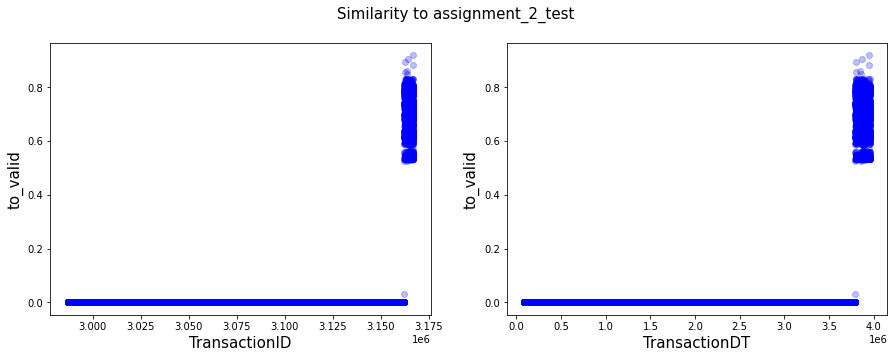

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Similarity to assignment_2_test", size=15)
axes[0].scatter(data['TransactionID'], data['to_valid'], alpha=0.25, color="blue")
axes[0].set_xlabel("TransactionID", size=15)
axes[0].set_ylabel("to_valid", size=15)

axes[1].scatter(data['TransactionDT'], data['to_valid'], alpha=0.25, color="blue")
axes[1].set_xlabel("TransactionDT", size=15)
axes[1].set_ylabel("to_valid", size=15)

В конце тренировочного датасета имеет место большое число сэмплов, похожих на те, которые находятся в тестовом датасете.

In [33]:
y_train = x_train['isFraud']
y_valid = x_valid['isFraud']
x_train.drop(columns=['to_valid', 'isFraud'], inplace=True)
x_valid.drop(columns=['to_valid', 'isFraud'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
cb_params = {
    "n_estimators": 5000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [35]:
model_catb_4 = cb.CatBoostClassifier(**cb_params)
model_catb_4.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6502187	test: 0.5329089	best: 0.5329089 (0)	total: 15ms	remaining: 1m 15s
50:	learn: 0.8658970	test: 0.8552340	best: 0.8552403 (49)	total: 634ms	remaining: 1m 1s
100:	learn: 0.8817877	test: 0.8807099	best: 0.8807099 (99)	total: 1.12s	remaining: 54.3s
150:	learn: 0.8871205	test: 0.8868394	best: 0.8868394 (150)	total: 1.59s	remaining: 51s
200:	learn: 0.8928361	test: 0.8966565	best: 0.8966565 (200)	total: 2.07s	remaining: 49.5s
250:	learn: 0.8954601	test: 0.8979405	best: 0.8983464 (246)	total: 2.54s	remaining: 48s
300:	learn: 0.8976179	test: 0.8995295	best: 0.8995375 (299)	total: 3.02s	remaining: 47.1s
350:	learn: 0.8999622	test: 0.9018946	best: 0.9018946 (350)	total: 3.47s	remaining: 46s
400:	learn: 0.9022156	test: 0.9043285	best: 0.9043503 (397)	total: 3.95s	remaining: 45.3s
450:	learn: 0.9036455	test: 0.9053890	best: 0.9053936 (444)	total: 4.41s	remaining: 44.5s
500:	learn: 0.9050251	test: 0.9068347	best: 0.9068920 (489)	total: 4.89s	remaining: 43.9s
550:	learn: 0.9072793	t

In [36]:
train_pred = model_catb_4.predict_proba(x_train)
valid_pred = model_catb_4.predict_proba(x_valid)
lb_pred = model_catb_4.predict_proba(x_lb)

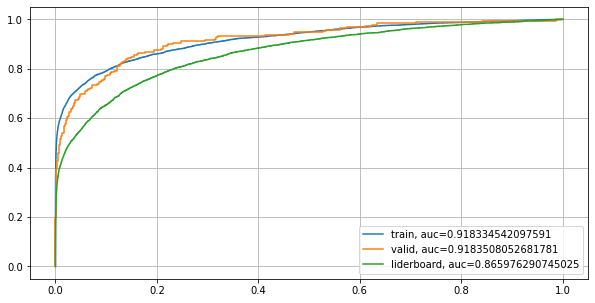

In [37]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_fpr_catb, lb_tpr_catb, _ = metrics.roc_curve(y_lb,  lb_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.plot(lb_fpr_catb, lb_tpr_catb, label="liderboard, auc="+str(lb_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [38]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb_4.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb_4.predict_proba(x_valid)[:, 1], roc_auc_score)
lb_scores = create_bootstrap_metrics(y_lb, model_catb_4.predict_proba(x_lb)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Lb confidence interval = {calculate_confidence_interval(lb_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9133543740893583, 0.9230153253824713)
Valid confidence interval = (0.8937918307387926, 0.940561479061479)
Lb confidence interval = (0.8592839078628125, 0.8722653334801912)
Liderboard score = 0.865976290745025


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

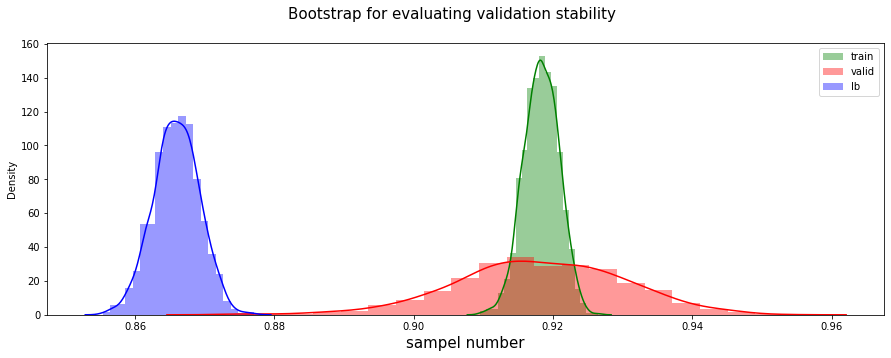

In [39]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.distplot(train_scores,  color="green", bins=20, label='train')
sns.distplot(valid_scores,  color="red", bins=20, label='valid')
sns.distplot(lb_scores,  color="blue", bins=20, label='lb')
plt.xlabel("sampel number", size=15)
plt.legend()

Вывод: после того, как мы стали валидироваться только на тех сэмплах, которые отличны от тех, на которых мы обучались, исчезло смещение в доверительных интервалах AUC для train и valid (точность на valid значительно выросла). Точность на liderboard выросла с 0.855 до 0.866. Но доверительный интервал для lb остался таким же смещенным относительно train и valid. Можно предположить, что если в lb оставить сэмплы, не похожие на находящиеся в train и valid, то все доверительные интервалы будут несмещенными

## Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [40]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [44]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

In [45]:
y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

In [46]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=False, random_state=1,
)

In [50]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

In [51]:
model_catb_5 = cb.CatBoostClassifier(**cb_params)

In [52]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train[numerical_features], y_train, model_catb_5, metric=roc_auc_score, cv_strategy=cv_strategy
)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0:	learn: 0.6839398	total: 10.8ms	remaining: 53.8s
50:	learn: 0.8586115	total: 484ms	remaining: 47s
100:	learn: 0.8694688	total: 876ms	remaining: 42.5s
150:	learn: 0.8777067	total: 1.27s	remaining: 40.7s
200:	learn: 0.8842461	total: 1.64s	remaining: 39.2s
250:	learn: 0.8874175	total: 2s	remaining: 37.9s
300:	learn: 0.8896884	total: 2.37s	remaining: 37s
350:	learn: 0.8917524	total: 2.73s	remaining: 36.2s
400:	learn: 0.8951731	total: 3.09s	remaining: 35.4s
450:	learn: 0.8977128	total: 3.46s	remaining: 34.9s
500:	learn: 0.8997640	total: 3.81s	remaining: 34.2s
550:	learn: 0.9008009	total: 4.16s	remaining: 33.6s
600:	learn: 0.9025946	total: 4.52s	remaining: 33.1s
650:	learn: 0.9040779	total: 4.87s	remaining: 32.6s
700:	learn: 0.9052250	total: 5.24s	remaining: 32.2s
750:	learn: 0.9060917	total: 5.61s	remaining: 31.8s
800:	learn: 0.9079864	total: 5.96s	remaining: 31.3s
850:	learn: 0.9090169	total: 6.32s	remaining: 30.8s
900:	learn: 0.9105673	total: 6.68s	remaining: 30.4s
950:	learn: 0.9114300

In [53]:
train_pred = model_catb_5.predict_proba(x_train[numerical_features])
valid_pred = model_catb_5.predict_proba(x_valid[numerical_features])
lb_pred = model_catb_5.predict_proba(x_lb[numerical_features])

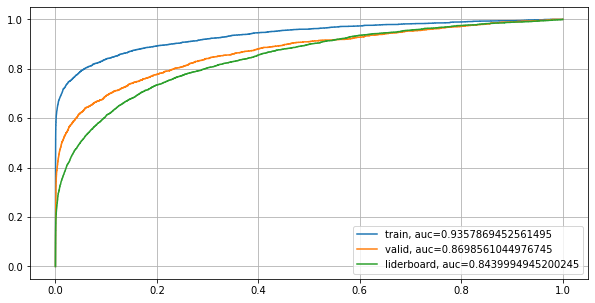

In [54]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
lb_fpr_catb, lb_tpr_catb, _ = metrics.roc_curve(y_lb,  lb_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.plot(lb_fpr_catb, lb_tpr_catb, label="liderboard, auc="+str(lb_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [55]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb_5.predict_proba(x_train[numerical_features])[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb_5.predict_proba(x_valid[numerical_features])[:, 1], roc_auc_score)
lb_scores = create_bootstrap_metrics(y_lb, model_catb_5.predict_proba(x_lb[numerical_features])[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Lb confidence interval = {calculate_confidence_interval(lb_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9297470461250635, 0.9411803471595076)
Valid confidence interval = (0.8605560290746121, 0.8795453180044395)
Lb confidence interval = (0.8365149074610858, 0.8510166422897424)
Liderboard score = 0.8439994945200245


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

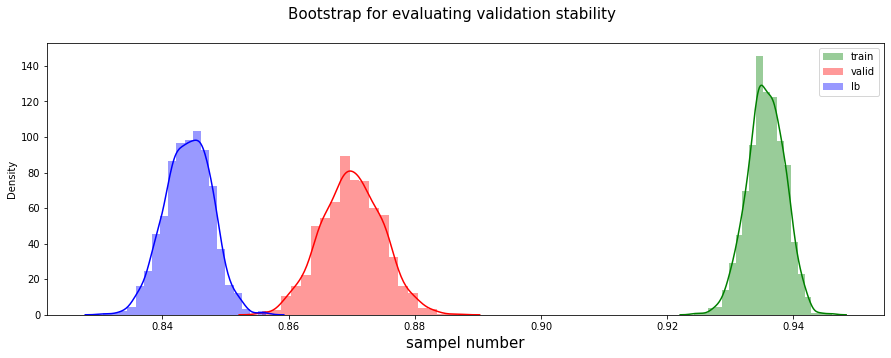

In [56]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.distplot(train_scores,  color="green", bins=20, label='train')
sns.distplot(valid_scores,  color="red", bins=20, label='valid')
sns.distplot(lb_scores,  color="blue", bins=20, label='lb')
plt.xlabel("sampel number", size=15)
plt.legend()

Вывод: использование перекрестной валидации привело еще к большему разрыву в AUC на train и valid. Результат на liderboard не попал в доверительный интервал на valid. В процессе кросс-валидации полученные метрики оказались гораздо ниже итоговых. 

## Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [57]:
data = pd.read_csv("/content/drive/MyDrive/assignment_2_train.csv")
lb = pd.read_csv("/content/drive/MyDrive/assignment_2_test.csv")

In [58]:
data.sort_values(by='TransactionDT', inplace=True, ascending=True)

In [59]:
categorical = data.select_dtypes(include='object')
categorical_feature_names = categorical.columns.to_list()

In [60]:
for feature in categorical_feature_names:
    data[feature] = data[feature].astype(str)
    lb[feature] = lb[feature].astype(str)

In [61]:
y_lb = lb['isFraud']
x_lb = lb.drop(columns=['isFraud'])

y = data['isFraud']
X = data.drop(columns=['isFraud'])

In [62]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.6, shuffle=False, random_state=1,
)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, y_valid, train_size=0.5, shuffle=False, random_state=1,
)

In [63]:
cb_params = {
    "n_estimators": 5000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27,
    'learning_rate': 0.1,
    'task_type': 'GPU',
    'one_hot_max_size': 100
}

In [64]:
model_catb_6 = cb.CatBoostClassifier(**cb_params)
model_catb_6.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], cat_features=categorical_feature_names)

0:	learn: 0.6734405	test: 0.6516944	best: 0.6516944 (0)	total: 16.4ms	remaining: 1m 22s
50:	learn: 0.8663189	test: 0.8492354	best: 0.8493204 (49)	total: 645ms	remaining: 1m 2s
100:	learn: 0.8786885	test: 0.8596828	best: 0.8596829 (99)	total: 1.11s	remaining: 54.1s
150:	learn: 0.8834132	test: 0.8625378	best: 0.8627122 (141)	total: 1.6s	remaining: 51.3s
200:	learn: 0.8881715	test: 0.8660166	best: 0.8660166 (200)	total: 2.06s	remaining: 49.1s
250:	learn: 0.8929076	test: 0.8678997	best: 0.8679869 (247)	total: 2.52s	remaining: 47.7s
300:	learn: 0.8954273	test: 0.8693374	best: 0.8693382 (298)	total: 2.97s	remaining: 46.4s
350:	learn: 0.8982363	test: 0.8715367	best: 0.8715367 (350)	total: 3.43s	remaining: 45.5s
400:	learn: 0.9006917	test: 0.8722298	best: 0.8722399 (399)	total: 3.92s	remaining: 45s
450:	learn: 0.9026832	test: 0.8734644	best: 0.8735213 (448)	total: 4.38s	remaining: 44.2s
500:	learn: 0.9044489	test: 0.8748258	best: 0.8748783 (498)	total: 4.85s	remaining: 43.5s
550:	learn: 0.9057

In [65]:
train_pred = model_catb_6.predict_proba(x_train)
valid_pred = model_catb_6.predict_proba(x_valid)
test_pred = model_catb_6.predict_proba(x_test)
lb_pred = model_catb_6.predict_proba(x_lb)

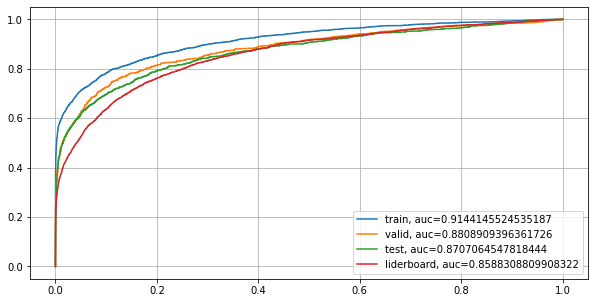

In [66]:
fig = plt.figure(figsize=(10, 5))
train_fpr_catb, train_tpr_catb, _ = metrics.roc_curve(y_train,  train_pred[:, 1])
train_auc_catb = metrics.roc_auc_score(y_train, train_pred[:, 1])
valid_fpr_catb, valid_tpr_catb, _ = metrics.roc_curve(y_valid,  valid_pred[:, 1])
valid_auc_catb = metrics.roc_auc_score(y_valid, valid_pred[:, 1])
test_fpr_catb, test_tpr_catb, _ = metrics.roc_curve(y_test,  test_pred[:, 1])
test_auc_catb = metrics.roc_auc_score(y_test, test_pred[:, 1])
lb_fpr_catb, lb_tpr_catb, _ = metrics.roc_curve(y_lb,  lb_pred[:, 1])
lb_auc_catb = metrics.roc_auc_score(y_lb, lb_pred[:, 1])
plt.plot(train_fpr_catb, train_tpr_catb, label="train, auc="+str(train_auc_catb))
plt.plot(valid_fpr_catb, valid_tpr_catb, label="valid, auc="+str(valid_auc_catb))
plt.plot(test_fpr_catb, test_tpr_catb, label="test, auc="+str(test_auc_catb))
plt.plot(lb_fpr_catb, lb_tpr_catb, label="liderboard, auc="+str(lb_auc_catb))
plt.legend(loc=4)
plt.grid()
plt.show()

In [67]:
np.random.seed(27)
train_scores = create_bootstrap_metrics(y_train, model_catb_6.predict_proba(x_train)[:, 1], roc_auc_score)
valid_scores = create_bootstrap_metrics(y_valid, model_catb_6.predict_proba(x_valid)[:, 1], roc_auc_score)
test_scores = create_bootstrap_metrics(y_test, model_catb_6.predict_proba(x_test)[:, 1], roc_auc_score)
lb_scores = create_bootstrap_metrics(y_lb, model_catb_6.predict_proba(x_lb)[:, 1], roc_auc_score)
print(f'Train confidence interval = {calculate_confidence_interval(train_scores)}')
print(f'Valid confidence interval = {calculate_confidence_interval(valid_scores)}')
print(f'Test confidence interval = {calculate_confidence_interval(test_scores)}')
print(f'Lb confidence interval = {calculate_confidence_interval(lb_scores)}')
print(f'Liderboard score = {lb_auc_catb}')

Train confidence interval = (0.9074830506076219, 0.9209240598974576)
Valid confidence interval = (0.8674921153940742, 0.8929874354166495)
Test confidence interval = (0.8595920488335932, 0.8820439937724053)
Lb confidence interval = (0.8521048150610748, 0.8656297395461208)
Liderboard score = 0.8588308809908322


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

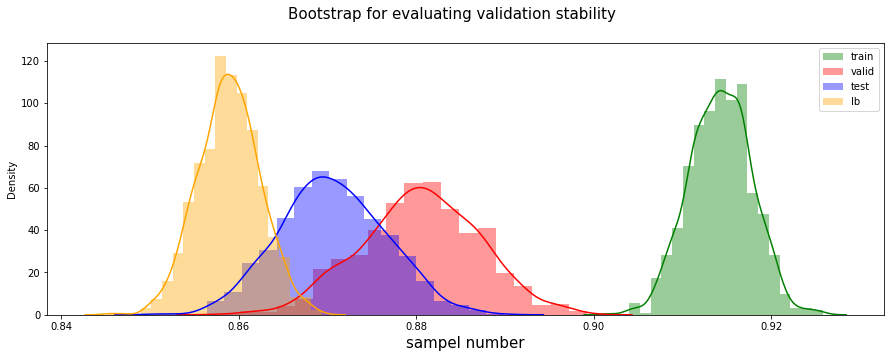

In [68]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.distplot(train_scores,  color="green", bins=20, label='train')
sns.distplot(valid_scores,  color="red", bins=20, label='valid')
sns.distplot(test_scores,  color="blue", bins=20, label='test')
sns.distplot(lb_scores,  color="orange", bins=20, label='lb')
plt.xlabel("sampel number", size=15)
plt.legend()

Вывод: результат почти совпадает с тем, который получен в пунктах 2,3. Это доказывает то, что TransactionID и TransactionDT имеют прямую линейную связь. При сортировке по одному и другому признаку порядок данных в датасете не меняется. train, valid и test выборки при разбиении по TransactionID не будут отличаться от тех, которые разбивались по TransactionDT. Также по результатам видно, что скор на лидерборде не попал в доверительный интервал на тестовой выборке. Ярко выражен сдвиг доверительных интервалов, что свидетельствует о том, что со временем (увеличением TransactionID и TransactionDT) распределения в данных изменялось. Поэтому разделять исходный датасет на части по этим признакам неправильно.